# 2024 Project

# NSW Electricity Demand Forecast

## Data Exploration

### Read Data

We use 4 data sources: temperature_nsw.csv (provided by the course), totaldemand_nsw.csv (provided by the course), population_nsw.csv (collected from the [website of Austraian Bureau of Statistics](https://www.abs.gov.au/statistics/people/population/national-state-and-territory-population/dec-2022)) and GDP.csv (collected from the [website of Austraian Bureau of Statistics](https://www.abs.gov.au/statistics/economy/national-accounts/australian-national-accounts-national-income-expenditure-and-product/latest-release#state-and-territory-final-demand)). These datasets encompass crucial variables for our analysis, namely temperature, population, GDP, and energy demand. However, the GDP data reflects the national figure rather than being specific to New South Wales (NSW), as such detailed state-level data was not accessible. To adjust for this, we proceed under the assumption that GDP trends in NSW are representative of the national average, thereby applying the Australia-wide GDP statistics to our NSW-centric forecasting model.

In [1]:
# Import necessary libaraies
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# Read Temperature file
df_temp = pd.read_csv('../data/NSW/temperature_nsw.csv')
df_temp.columns = df_temp.columns.str.lower()

In [3]:
# Read totaldemand file
df_demand = pd.read_csv('../data/NSW/totaldemand_nsw.csv')
df_demand.columns = df_demand.columns.str.lower()

In [4]:
# Read population file
df_population = pd.read_csv('../data/NSW/population_nsw.csv')
df_population.columns = df_population.columns.str.lower()

In [5]:
# Read GDP file
df_gdp = pd.read_csv('../data/NSW/GDP.csv')
df_gdp.columns = df_gdp.columns.str.lower()

### First glance at the data

In [6]:
df_temp.head()

,location,datetime,temperature
0,Bankstown,1/1/2010 0:00,23.1
1,Bankstown,1/1/2010 0:01,23.1
2,Bankstown,1/1/2010 0:30,22.9
3,Bankstown,1/1/2010 0:50,22.7
4,Bankstown,1/1/2010 1:00,22.6


In [7]:
df_temp['location'].nunique()

1

In [8]:
df_demand.head()

,datetime,totaldemand,regionid
0,1/1/2010 0:00,8038.00,NSW1
1,1/1/2010 0:30,7809.31,NSW1
2,1/1/2010 1:00,7483.69,NSW1
3,1/1/2010 1:30,7117.23,NSW1
4,1/1/2010 2:00,6812.03,NSW1


In [9]:
df_demand['regionid'].nunique()

1

In [10]:
df_population.head()

,time,population
0,Dec-2009,7101504
1,Mar-2010,7128356
2,Jun-2010,7144292
3,Sep-2010,7162726
4,Dec-2010,7179891


In [11]:
df_gdp.head()

,time,gdp
0,Dec-2009,334934
1,Mar-2010,314838
2,Jun-2010,340575
3,Sep-2010,345512
4,Dec-2010,365403


### Check Correlation between demand and each variables

#### Temperature and Demand

In [12]:
df_temp_demand = pd.merge(df_temp, df_demand, on='datetime')

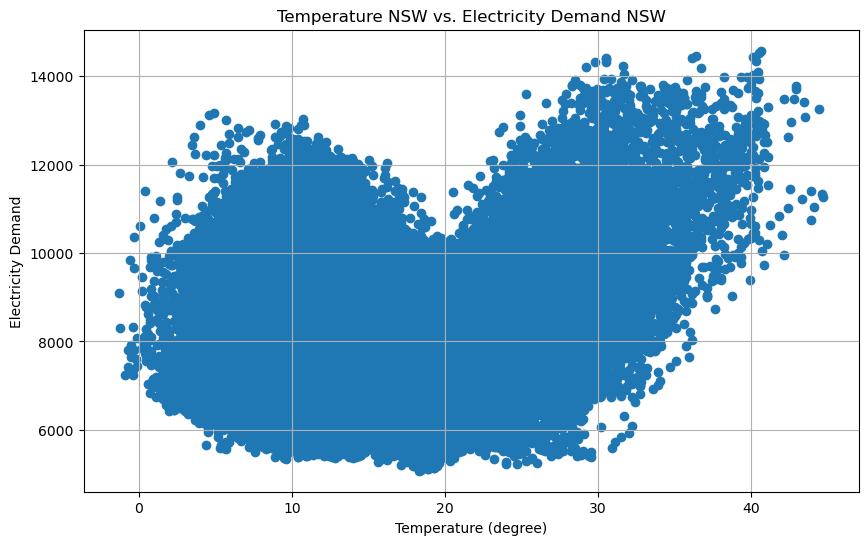

In [13]:
plt.figure(figsize=(10, 6))
plt.scatter(df_temp_demand['temperature'], df_temp_demand['totaldemand'])
plt.title('Temperature NSW vs. Electricity Demand NSW')
plt.xlabel('Temperature (degree)')
plt.ylabel('Electricity Demand')
plt.grid(True)
plt.show()

As depicted in the graph, it resembles a V shape. Below approximately 20 degrees, the demand increases as the temperature decreases; above 20 degrees, the demand rises with increasing temperature. This pattern aligns with our everyday experience. Temperature is useful in our modeling. 

#### Population and Demand

The demand is recorded every 30 mins while GDP quarterly. We shall aggregate the electricity demand to a quarterly frequency. We can calculate the average demand for each quarter. 

In [14]:
df_demand['time'] = pd.to_datetime(df_demand['datetime'], format='%d/%m/%Y %H:%M') 

In [15]:
df_demand.set_index('time', inplace=True) 
total_demand_quarterly = df_demand['totaldemand'].resample('Q').mean()
df_total_demand_quarterly = total_demand_quarterly.reset_index()

In [16]:
df_total_demand_quarterly['normalized_demand'] = (df_total_demand_quarterly['totaldemand'] - df_total_demand_quarterly['totaldemand'].mean()) / df_total_demand_quarterly['totaldemand'].std()

In [17]:
df_population['time'] = pd.to_datetime(df_population['time'], format='%b-%Y')
df_population['time'] = df_population['time'] + pd.offsets.MonthEnd(1)
df_population['normalized_population'] = (df_population['population'] - df_population['population'].mean()) / df_population['population'].std()

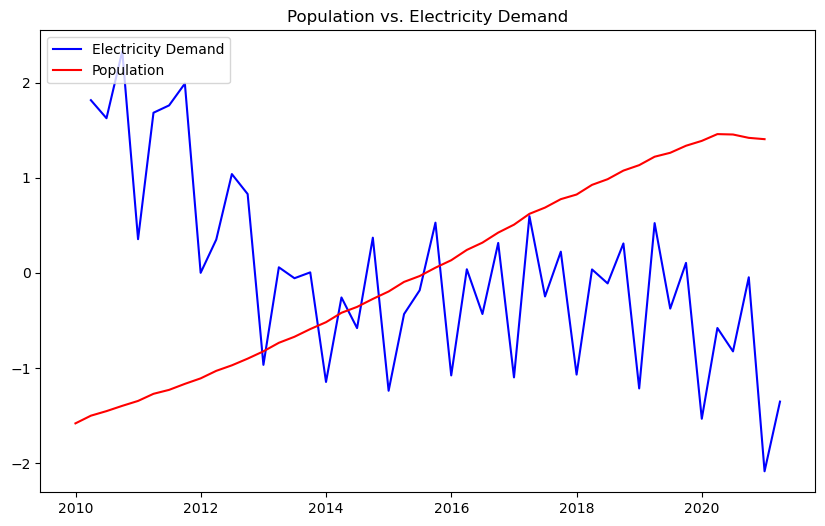

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(df_total_demand_quarterly['time'], df_total_demand_quarterly['normalized_demand'], label='Electricity Demand', color='blue')
plt.plot(df_population['time'], df_population['normalized_population'], label='Population', color='red')
plt.legend(loc='upper left')
plt.title('Population vs. Electricity Demand')
plt.show()

This is very interesting. As the population grows, we would typically expect electricity demand to rise, assuming individual consumption remains steady. Contrary to this expectation, we observe a decline in electricity demand. This suggests that the per capita electricity demand is decreasing. Possible explanations for this trend might include a relative decrease in personal income against the cost of electricity, prompting individuals to limit usage, or the adoption of alternative energy sources, like residential solar panels, reducing reliance on traditional electricity supplies.

GDP can rougly (if not totally) represent the income of citizens. Let's check GDP trend first.

#### GDP and Demand

In [19]:
df_gdp['time'] = pd.to_datetime(df_gdp['time'], format='%b-%Y') + pd.offsets.MonthEnd(1)
df_gdp['normalized_gdp'] = (df_gdp['gdp'] - df_gdp['gdp'].mean()) / df_gdp['gdp'].std()

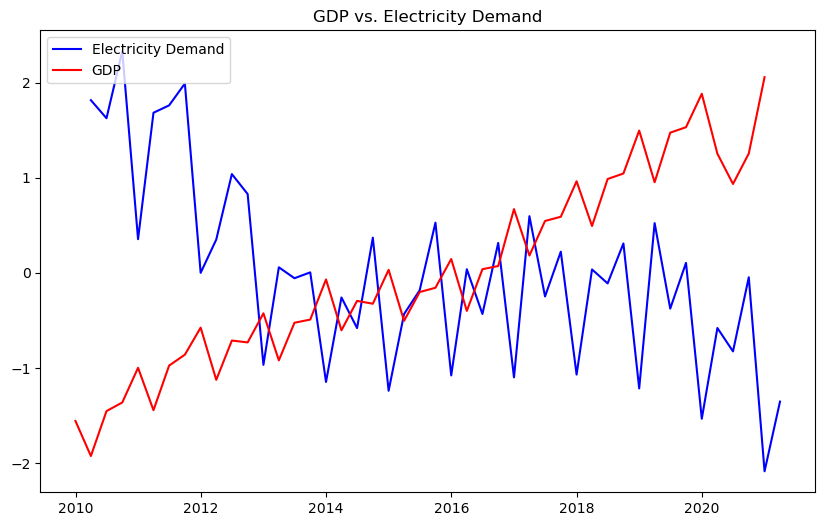

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(df_total_demand_quarterly['time'], df_total_demand_quarterly['normalized_demand'], label='Electricity Demand', color='blue')
plt.plot(df_gdp['time'], df_gdp['normalized_gdp'], label='GDP', color='red')
plt.legend(loc='upper left')
plt.title('GDP vs. Electricity Demand')
plt.show()

GDP kept increasing from 2010 to 2020. So could it be that the electricity price increased a lot during that period? 

So let's check the price over the last decade. We got the dataset from [CEIC's website](https://www.ceicdata.com/en/australia/electricity-prices/electricity-average-peak-price-new-south-wales). 

### Electricity Price over the last decade

In [21]:
df_electricity_price = pd.read_csv('../data/NSW/electricity_price_nsw.csv')
df_electricity_price.columns = df_electricity_price.columns.str.lower()

In [22]:
df_electricity_price

,year,region,avgrrp
0,2010,NSW,44.19
1,2011,NSW,36.74
2,2012,NSW,29.67
3,2013,NSW,55.10
4,2014,NSW,52.26
5,2015,NSW,35.17
6,2016,NSW,51.60
7,2017,NSW,81.22
8,2018,NSW,82.27
9,2019,NSW,88.56


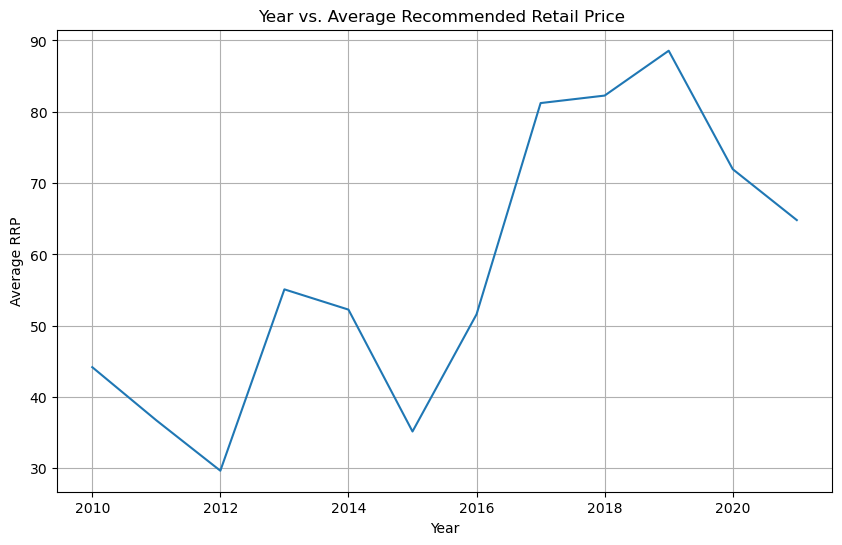

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(df_electricity_price['year'], df_electricity_price['avgrrp'])
plt.title('Year vs. Average Recommended Retail Price ')
plt.xlabel('Year')
plt.ylabel('Average RRP')
plt.grid(True)
plt.show()

We do see the price increased over the last decade. So in our modeling, it is better to include the factor of pricing. 

The increased adoption of residential solar panels might be another factor to consider, as this can lead to a reduction in dependency on conventional electricity grids. As more households install solar panels, the aggregate demand on traditional energy providers is likely to diminish. 

### Home Solar Installation over the last decade

We got Small-scale installation postcode data from [Clean Energy Regulator, Australian Government](https://cleanenergyregulator.gov.au/markets/reports-and-data/small-scale-installation-postcode-data#installation-numbers-for-small-scale-systems-by-state/territory). Let's see how many small-scall solar installation was done in the past a decade.

In [24]:
df_solar_install = pd.read_csv('../data/NSW/home_solar_nsw.csv')
df_solar_install.columns = df_solar_install.columns.str.lower()

In [25]:
df_solar_install

,year,nsw,solar_install
0,2009,"14,008","14,008"
1,2010,"69,988","83,996"
2,2011,"80,272","164,268"
3,2012,"53,961","218,229"
4,2013,"33,998","252,227"
5,2014,"37,210","289,437"
6,2015,"33,478","322,915"
7,2016,"29,498","352,413"
8,2017,"43,253","395,666"
9,2018,"59,329","454,995"


In [26]:
df_solar_install['solar_install'] = df_solar_install['solar_install'].str.replace(',', '')
df_solar_install['solar_install'] = df_solar_install['solar_install'].astype(int)

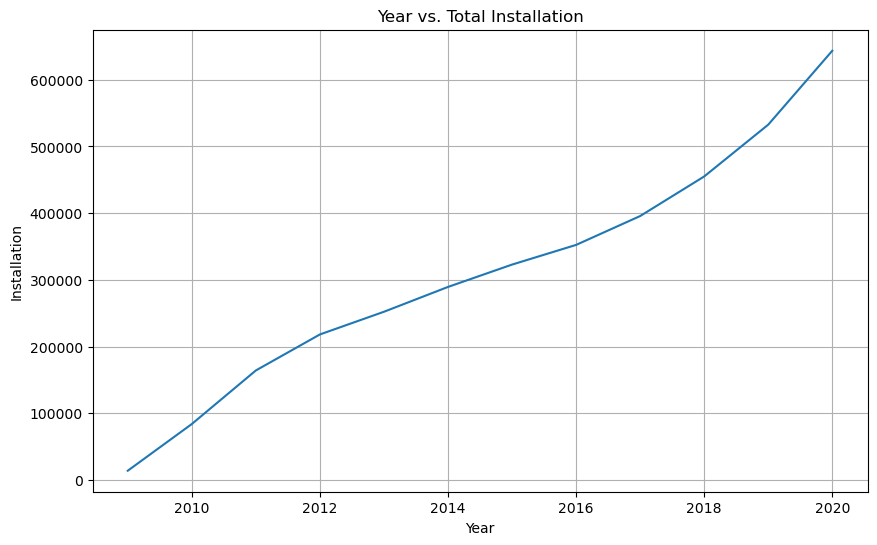

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(df_solar_install['year'], df_solar_install['solar_install'])
plt.title('Year vs. Total Installation')
plt.xlabel('Year')
plt.ylabel('Installation')
plt.grid(True)
plt.show()

We can see the installation increased over the last decase. It is reasonable to include the total installation in NSW into our model too. 

## Data Preperation For Modeling

### Which kind of prediction we want to do

We can predict the average demand for a quarter. As discussed above, such a prediction should consider factors including time, quarterly average temperature, population, GDP, price, and solar installations. 

We can also predict short-term demand every 30 minutes. For such predictions, long-term factors such as population, GDP, price, or solar installations will not play a significant role. Therefore, we will exclude them from our modeling.

### Long Term Data For Modeling

When predicting quartly demand, we should use population, average temperate, and GDP. In reality we can not get the data of these features before the end of the quarter we want to predict. So to compose the data for training and testing, we need to modify our dataset a bit. 

#### Population

In [28]:
df_population.head()

,time,population,normalized_population
0,2009-12-31,7101504,-1.582523
1,2010-03-31,7128356,-1.501659
2,2010-06-30,7144292,-1.453668
3,2010-09-30,7162726,-1.398155
4,2010-12-31,7179891,-1.346464


In [29]:
df_population_quarterly = df_population.copy(deep=True)

In [30]:
# offset the time by 3 months
df_population_quarterly['time'] = df_population['time'] + pd.DateOffset(months=3)
df_population_quarterly['time'] = df_population_quarterly['time'] + pd.offsets.MonthEnd(0)

#### GDP

In [31]:
df_gdp.head()

,time,gdp,normalized_gdp
0,2009-12-31,334934,-1.557029
1,2010-03-31,314838,-1.925885
2,2010-06-30,340575,-1.453491
3,2010-09-30,345512,-1.362874
4,2010-12-31,365403,-0.997781


In [32]:
df_gdp_quarterly = df_gdp.copy(deep=True)

In [33]:
df_gdp_quarterly['time'] = df_gdp['time'] + pd.DateOffset(months=3)
df_gdp_quarterly['time'] = df_gdp_quarterly['time'] + pd.offsets.MonthEnd(0)

#### Solar Installation

In [34]:
df_solar_install.head()

,year,nsw,solar_install
0,2009,"14,008",14008
1,2010,"69,988",83996
2,2011,"80,272",164268
3,2012,"53,961",218229
4,2013,"33,998",252227


We only have annual data. We can convert yearly solar installation data to quarterly data using linear interpolation within each year.

In [35]:
quarterly_solar_install = {'year_quarter': [], 'solar_install': []}

for i in range(len(df_solar_install)):
    if i == 0:
        growth = (df_solar_install.loc[i + 1, 'solar_install'] - df_solar_install.loc[i, 'solar_install']) / 4
        for q in range(1, 5):
            quarterly_solar_install['year_quarter'].append(f"{df_solar_install.loc[i, 'year']}-Q{q}")
            quarterly_solar_install['solar_install'].append(int(df_solar_install.loc[i, 'solar_install'] + growth * (q - 1)))
    else:
        growth = (df_solar_install.loc[i, 'solar_install'] - df_solar_install.loc[i - 1, 'solar_install']) / 4
        for q in range(1, 5):
            quarterly_solar_install['year_quarter'].append(f"{df_solar_install.loc[i, 'year']}-Q{q}")
            quarterly_solar_install['solar_install'].append(int(df_solar_install.loc[i, 'solar_install'] + growth * (q - 1)))

df_quarterly_solar_install = pd.DataFrame(quarterly_solar_install)

In [36]:
df_quarterly_solar_install.head()

,year_quarter,solar_install
0,2009-Q1,14008
1,2009-Q2,31505
2,2009-Q3,49002
3,2009-Q4,66499
4,2010-Q1,83996


In [37]:
def quarter_to_date(quarter_str):
    year, q = quarter_str.split('-')
    if q == 'Q1':
        return f'{year}-03-31'
    elif q == 'Q2':
        return f'{year}-06-30'
    elif q == 'Q3':
        return f'{year}-09-30'
    elif q == 'Q4':
        return f'{year}-12-31'

In [38]:
df_quarterly_solar_install['time'] = df_quarterly_solar_install['year_quarter'].apply(quarter_to_date)

# Convert the 'end_of_quarter' column to datetime
df_quarterly_solar_install['time'] = pd.to_datetime(df_quarterly_solar_install['time'])
# Offset the time by 1 year
df_quarterly_solar_install['time'] = df_quarterly_solar_install['time'] + pd.DateOffset(months=12)

In [39]:
df_quarterly_solar_install.head()

,year_quarter,solar_install,time
0,2009-Q1,14008,2010-03-31
1,2009-Q2,31505,2010-06-30
2,2009-Q3,49002,2010-09-30
3,2009-Q4,66499,2010-12-31
4,2010-Q1,83996,2011-03-31


#### Price

In [40]:
df_electricity_price.head()

,year,region,avgrrp
0,2010,NSW,44.19
1,2011,NSW,36.74
2,2012,NSW,29.67
3,2013,NSW,55.10
4,2014,NSW,52.26


In [41]:
# Same as what we did to solar install, convert price to quartely data
quarterly_price = {'year_quarter': [], 'avgrrp': []}

for i in range(len(df_electricity_price)):
    if i == 0:
        growth = (df_electricity_price.loc[i + 1, 'avgrrp'] - df_electricity_price.loc[i, 'avgrrp']) / 4
        for q in range(1, 5):
            quarterly_price['year_quarter'].append(f"{df_electricity_price.loc[i, 'year']}-Q{q}")
            quarterly_price['avgrrp'].append(df_electricity_price.loc[i, 'avgrrp'] + growth * (q - 1))
    else:
        growth = (df_electricity_price.loc[i, 'avgrrp'] - df_electricity_price.loc[i - 1, 'avgrrp']) / 4
        for q in range(1, 5):
            quarterly_price['year_quarter'].append(f"{df_electricity_price.loc[i, 'year']}-Q{q}")
            quarterly_price['avgrrp'].append(df_electricity_price.loc[i, 'avgrrp'] + growth * (q - 1))

df_quarterly_electricity_price = pd.DataFrame(quarterly_price)

In [42]:
df_quarterly_electricity_price['time'] = df_quarterly_electricity_price['year_quarter'].apply(quarter_to_date)

# Convert the 'end_of_quarter' column to datetime
df_quarterly_electricity_price['time'] = pd.to_datetime(df_quarterly_electricity_price['time'])
# Offset the time by 1 year
df_quarterly_electricity_price['time'] = df_quarterly_electricity_price['time'] + pd.DateOffset(months=12)

#### Temperature

In [43]:
df_temp['time'] = pd.to_datetime(df_temp['datetime'], format='%d/%m/%Y %H:%M') 
df_temp.set_index('time', inplace=True) 
temp_quarterly = df_temp['temperature'].resample('Q').mean()
df_temp_quarterly = temp_quarterly.reset_index()
df_temp_quarterly['time'] = df_temp_quarterly['time'] + pd.DateOffset(months=3)
df_temp_quarterly['time'] = df_temp_quarterly['time'] + pd.offsets.MonthEnd(0)

#### Create the long term quarterly dataset for training and testing

In [44]:
df_temp_install = pd.merge(df_temp_quarterly, df_quarterly_solar_install, on='time', how='inner')
df_temp_install_price = pd.merge(df_temp_install, df_quarterly_electricity_price, on='time', how='inner')
df_temp_install_price_gdp = pd.merge(df_temp_install_price, df_gdp_quarterly, on='time', how='inner')
df_temp_install_price_gdp_population = pd.merge(df_temp_install_price_gdp, df_population_quarterly, on='time', how='inner')
df_temp_install_price_gdp_population_demand = pd.merge(df_temp_install_price_gdp_population, df_total_demand_quarterly, on='time', how='inner')

**NOTE:** Depending on which model to use, 'time' may not be used in some models.

In [45]:
df_long_term = df_temp_install_price_gdp_population_demand[['time', 'temperature', 'solar_install', 'avgrrp', 'gdp', 'population', 'totaldemand']]

In [46]:
y_long_term = df_long_term['totaldemand']
X_long_term = df_long_term.drop('totaldemand', axis = 1)

In [47]:
X_long_term_train, X_long_term_test, y_long_term_train, y_long_term_test = train_test_split(X_long_term, y_long_term, test_size=0.2, random_state=42)

### Short Term Data For Modeling

In [48]:
df_temp = df_temp.reset_index()

In [49]:
df_demand = df_demand.reset_index()

In [50]:
df_temp_demand_short_term = pd.merge(df_temp, df_demand, on='time', how='inner')

**NOTE:** Depending on which model to use, 'time' may not be used in some models. 

In [51]:
df_short_term = df_temp_demand_short_term[['time', 'temperature', 'totaldemand']]

In [52]:
y_short_term = df_short_term['totaldemand']
X_short_term = df_short_term.drop('totaldemand', axis = 1)

In [54]:
X_short_term_train, X_short_term_test, y_short_term_train, y_short_term_test = train_test_split(X_short_term, y_short_term, test_size=0.2, random_state=42)